# Backlog scoring calculations
## How healthy is your backlog?

In the fast paced development project environment it's very important to have meaningful and easy to understand metrics. Those metrics are foundation of data-driven decisions and can give you and the team sense of direction in everyday actions.

Here, I'd like to present idea of backlog scoring - one number that could give you meaningful information about the shape of a backlog in your team. 

Quantified backlog state is simply sum of scoring for chosen rules that are summed and multiplied by maximium score. The result should be a number from 1-10 (1 - worst, 10 - best). 
$$Backlog\ Score=\sum_{i=0}^n score_i * weight_i * MaxScore$$ 

Using the persistence capabilities of Jupyter Notebook it will be also possible to track the trend of the scoring in time.


In [87]:
from jira import JIRA
import matplotlib.pyplot as plt
import pandas as pd
import re
from jira.client import GreenHopper
from numpy import nan
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Here I'd like to propose 4 rules:
* % of planned 2 sprints (Scrum development iterations). there are items in Backlog state that SP sum is equal to estimated velocity (+-20%), there are no items assigned to sprint that are not in Backlog state
* Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - [Y/N]
* % of Must, Urgent, Should items that are estimated regardless of status'
* % of key milestone (major version) items estimated and in Backlog status


Below you can see how to set up rules with weights. In my example most important is to ensure that next 2 sprints are planned. The 0 rule have weight of 0.4 and other rules weights are 0.25, 0.25 and 1. You can change those rules or add more. All weights need to sum up to 1.

Above rules make sense for our project. You can modify them or add new!


In [88]:
#to show full rules descriptions
pd.set_option('max_colwidth',200)

rules = pd.DataFrame()
rules['rule'] = ''
rules['weight'] = 0
rules['value'] = 0

rules['rule'] = ['% of planned 2 sprints. there are items in Backlog state that SP sum is equal to estimated velocity \
(+-20%), there are no items assigned to sprint that are not in Backlog state',
                'Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N',
                '% of Must, Urgent, Should items that are estimated regardless of status',
                '% of key milestone items estimated and in Backlog status']
rules['weight'] = [0.4, 0.25, 0.25, 0.1]

rules

,rule,weight,value
0,"% of planned 2 sprints. there are items in Backlog state that SP sum is equal to estimated velocity (+-20%), there are no items assigned to sprint that are not in Backlog state",0.40,NaN
1,Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N,0.25,NaN
2,"% of Must, Urgent, Should items that are estimated regardless of status",0.25,NaN
3,% of key milestone items estimated and in Backlog status,0.10,NaN


Rules sum should be equal to 1

In [89]:
sum(rules.weight)

1.0

<div class="alert alert-block alert-success">
Set up estimatedVelocity, nextVersion and milestones values.

They can be loaded automatically from Jira but this is not a scope of this article.
</div>

In [90]:
#velocity used to check if sprints are planned correctly
estimatedVelocity = 14

nextVersions = ['1.12', '1.13', '1.14', '1.15', '1.16']
milestones = ['Milestone X']

Jira address will be needed to load data. Credentials are stored in ~/.rcnet file.

In [91]:
jira_url = 'https://kainos-evolve.atlassian.net'
jira = JIRA(jira_url)

Board id need to be specified to download sprint information. You can find it in the address of your board in Jira.

<img src="./images/boardId.png" />

In [92]:
#download next 2 sprints names

options = {'server': jira_url}
gh = GreenHopper(options)

#you need to specify the board id
sprintsRaw = gh.sprints(285)

sprints = pd.DataFrame()
sprints['name'] = ''
sprints['state'] = ''

for sprint in sprintsRaw:
    sprints = sprints.append(
            {
                'name': sprint.name,
                'state': sprint.state
            }, ignore_index=True)

#we're interested only in not started sprints
sprints = sprints.loc[(sprints['state'] == 'FUTURE')]
sprints.sort_values("name", inplace=True)

nextSprints = sprints.head(2)['name'].tolist()
nextSprints

['IC - #5 20180305 - 1.14', 'IC - #6 20180319 - 1.14']

First rule focuses on the next 2 sprints. To achieve max result issues in 2 of next sprints should be refined and estimated. The calculated velocity for each next sprint should be similar to estimated in +-20% range.

In [93]:
#rule 0
#In next 2 sprints there are items in Backlog state that SP sum is equal to estimated velocity (+-20%), 
#there are no items assigned to sprint that are not in Backlog state 
#bugs don't have to be estimated

# find all issues in specified sprints that are not bugs and are in backlog status
jql = 'sprint in ("{}") and status in (Backlog, "Ready to test") and type not in subTaskIssueTypes()'.format('", "'.join(nextSprints))
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['sprint'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

for issue in issuesRaw:
    for rawSprint in issue.fields.customfield_10007:
        #unfortunately sprint information is encoded and regex is needed
        matches = re.search('name=(.*?),', rawSprint)
        currentSprint = matches.group(1)
        #we're only interested in issues assigned to specific sprints
        if(currentSprint in nextSprints):
            issues = issues.append(
                {
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP' : issue.fields.customfield_10005,
                 #'summary': issue.fields.summary,
                 'summary': 'Summary...',
                 'sprint' : currentSprint
                }, ignore_index=True)

issues.fillna(value=nan, inplace=True)
issues
#issues.fillna(0, inplace=True)


sprints = issues.groupby(['sprint']).agg({'SP':'sum'})
sprints
sprints = sprints.loc[(sprints['SP'] >= estimatedVelocity - estimatedVelocity * .2) &
                     (sprints['SP'] <= estimatedVelocity + estimatedVelocity * .2)]

#% of sprints that meet condition should be equal to number of next sprints
rule_value = len(sprints) / len(nextSprints)
rule_value
rules.at[0, 'value'] = rule_value

'sprint in ("IC - #5 20180305 - 1.14", "IC - #6 20180319 - 1.14") and status in (Backlog, "Ready to test") and type not in subTaskIssueTypes()'

,key,sprint,SP,type,status,summary
0,VXT-4087,IC - #6 20180319 - 1.14,2.0,Bug,Backlog,Summary...
1,VXT-4028,IC - #6 20180319 - 1.14,2.0,Story,Backlog,Summary...
2,VXT-4026,IC - #5 20180305 - 1.14,2.0,Bug,Backlog,Summary...
3,VXT-3993,IC - #6 20180319 - 1.14,3.0,Bug,Backlog,Summary...
4,VXT-3969,IC - #5 20180305 - 1.14,3.0,Story,Backlog,Summary...
5,VXT-3904,IC - #6 20180319 - 1.14,1.0,Story,Ready to Test,Summary...
6,VXT-3759,IC - #5 20180305 - 1.14,3.0,Story,Backlog,Summary...
7,VXT-3678,IC - #6 20180319 - 1.14,3.0,Story,Backlog,Summary...
8,VXT-3082,IC - #5 20180305 - 1.14,8.0,Story,Ready to Test,Summary...
9,VXT-2066,IC - #6 20180319 - 1.14,1.0,Story,Backlog,Summary...


,SP
sprint,
IC - #5 20180305 - 1.14,18.0
IC - #6 20180319 - 1.14,12.0


0.5

2nd rule checks if 3 next versions in Jira (manually set up above) are initially estimated. Initial estimation in Story Points with team velocity can give us view on when the team will be ready to deliver specified versions. 

To see how to create stacked burndown for multiple versions see: [https://github.com/robert-krasinski/JiraAndPythonForManagers/blob/master/Burndown%20chart%20for%20multiple%20versions.ipynb]

In [94]:
#rule 1 Planned next 3 versions (all items estimated and in Backlog or started state (not in state before backlog) - Y/N
jql = 'fixVersion in ("{}") and type not in subTaskIssueTypes()'.format('", "'.join(nextVersions))
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        #only specific versions should be taken into consideration
        if(fixVersion.name in nextVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 #'summary': issue.fields.summary,
                 'summary': 'Summary...',
                 'team' : str(issue.fields.customfield_14200),
                }, ignore_index=True)

#completed and rejected issues don't need to be estimated       
issues = issues.loc[~(issues['status'].isin(['Completed', 'Rejected']))]

#indicate not estimated issues, bugs don't have to be estimated
issues['isEstimated'] = False
issues.loc[(issues['type'].isin(['Bug', 'Epic'])), ['isEstimated']] = True
issues.loc[(issues['type'] != 'Bug') & ~(issues['SP'].isnull()), ['isEstimated']] = True

#indicate items in presprint. PreSprint states in this case are the states before Backlog. Item needs to be refined
#before a team start working on them.

issues['inPresprint'] = False
issues.loc[(issues['status'].isin(['Awaiting Prioritisation', 'PO Refinement', 'UX Refinement', 'QA Refinement', 'Tech Refinement', 
                                  'Tech Refinement', 'Estimation'])), ['inPresprint']] = True
issues.sort_values("version", inplace=True)


issues = issues.loc[(issues['inPresprint'] == True) | (issues['isEstimated'] == False)]
issues

#there should be no issues without SP and in earlier states than Backlog 
rule_value = len(issues) == 0
rules.at[1, 'value'] = int(rule_value)


'fixVersion in ("1.12", "1.13", "1.14", "1.15", "1.16") and type not in subTaskIssueTypes()'

,key,version,SP,type,status,summary,team,isEstimated,inPresprint
42,VXT-3736,1.13,NaN,Bug,QA Refinement,Summary...,Gdansk Team 1,True,True
31,VXT-3938,1.13,NaN,Story,Tech Refinement,Summary...,Gdansk Team 1,False,True
11,VXT-4061,1.15,8.0,Story,Tech Refinement,Summary...,Gdansk Team 1,True,True
10,VXT-4062,1.15,8.0,Story,Tech Refinement,Summary...,Gdansk Team 1,True,True
9,VXT-4063,1.15,NaN,Story,Tech Refinement,Summary...,Gdansk Team 1,False,True
8,VXT-4064,1.15,NaN,Story,Tech Refinement,Summary...,Gdansk Team 1,False,True
7,VXT-4065,1.15,NaN,Story,Tech Refinement,Summary...,Gdansk Team 1,False,True
6,VXT-4066,1.15,NaN,Story,Tech Refinement,Summary...,Gdansk Team 1,False,True
26,VXT-3986,1.16,NaN,Story,Backlog,Summary...,Gdansk Team 1,False,False


3rd rule ensures that high priority items are estimated (except Bug type). There is plenty of space for improvement here. For example you could measure how many high priority bugs in Backlog are stored there specific time treshold.

In [95]:
#rule 2
# % of Must, Urgent, Should items that are estimated regardless of status
# bugs don't have to be estimated
jql = 'project = VXT and priority in (Must,Urgent,Should) and type != Bug and type not in subTaskIssueTypes() \
and status not in (Rejected, Completed)'
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''
issues['priority'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        #only specific versions are needed (issue may be assigned to many)
        if(fixVersion.name in nextVersions):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 #'summary': issue.fields.summary,
                 'summary': 'Summary...',
                 'priority' : str(issue.fields.priority.name),
                }, ignore_index=True)
issues

rule_value = round(len(issues.loc[~(issues['SP'].isnull())]) / len(issues), 2)
rules.at[2, 'value'] = rule_value

'project = VXT and priority in (Must,Urgent,Should) and type != Bug and type not in subTaskIssueTypes() and status not in (Rejected, Completed)'

,key,version,SP,type,status,summary,priority
0,VXT-4110,1.13,3.0,Story,In Development,Summary...,MUST
1,VXT-4109,1.13,3.0,Story,Backlog,Summary...,URGENT
2,VXT-4100,1.13,3.0,Story,In Development,Summary...,URGENT
3,VXT-4098,1.12,1.0,Story,In Development,Summary...,SHOULD
4,VXT-4092,1.12,2.0,Story,In Testing,Summary...,SHOULD
5,VXT-4066,1.15,NaN,Story,Tech Refinement,Summary...,SHOULD
6,VXT-4065,1.15,NaN,Story,Tech Refinement,Summary...,MUST
7,VXT-4064,1.15,NaN,Story,Tech Refinement,Summary...,MUST
8,VXT-4063,1.15,NaN,Story,Tech Refinement,Summary...,MUST
9,VXT-4062,1.15,8.0,Story,Tech Refinement,Summary...,MUST


In this particular project versions are grouped into bigger milestone releases. The important information is how many of those milestone items are estimated and ready to be picked up by developers. 4th rule is checking this.

In [96]:
# % of key milestone items estimated and in Backlog status
jql = 'project = VXT and type != Epic and status not in (Rejected, Completed) and \
type not in subTaskIssueTypes() and fixVersion in ("' + '", "'.join(milestones) + '")'
jql

issuesRaw = jira.search_issues(jql)

issues = pd.DataFrame()
issues['key'] = ''
issues['version'] = ''
issues['SP'] = ''
issues['type'] = ''
issues['status'] = ''
issues['summary'] = ''

#add issues to dataframe
for issue in issuesRaw:
    #issue may have many versions - in this approach, one version per issue is recommended
    for fixVersion in issue.fields.fixVersions:
        if(fixVersion.name in milestones):
            issues = issues.append(
                {'version': fixVersion.name, 
                 'key': issue.key,
                 'type': issue.fields.issuetype.name,
                 'status': issue.fields.status.name,
                 'SP': issue.fields.customfield_10005,
                 #'summary': issue.fields.summary,
                 'summary': 'Summary...',
                }, ignore_index=True)
            
issues['isEstimated'] = False
issues.loc[(issues['type'] == 'Bug'), ['isEstimated']] = True
issues.loc[(issues['type'] != 'Bug') & ~(issues['SP'].isnull()), ['isEstimated']] = True
issues

rule_value = round(len(issues.loc[(issues['isEstimated'] == True)]) / len(issues), 2)
rule_value
rules.at[3, 'value'] = rule_value

'project = VXT and type != Epic and status not in (Rejected, Completed) and type not in subTaskIssueTypes() and fixVersion in ("Frimley MVP")'

,key,version,SP,type,status,summary,isEstimated
0,VXT-4110,Frimley MVP,3.0,Story,In Development,Summary...,True
1,VXT-4109,Frimley MVP,3.0,Story,Backlog,Summary...,True
2,VXT-4100,Frimley MVP,3.0,Story,In Development,Summary...,True
3,VXT-4098,Frimley MVP,1.0,Story,In Development,Summary...,True
4,VXT-4087,Frimley MVP,2.0,Bug,Backlog,Summary...,True
5,VXT-4085,Frimley MVP,NaN,Bug,Backlog,Summary...,True
6,VXT-4066,Frimley MVP,NaN,Story,Tech Refinement,Summary...,False
7,VXT-4065,Frimley MVP,NaN,Story,Tech Refinement,Summary...,False
8,VXT-4064,Frimley MVP,NaN,Story,Tech Refinement,Summary...,False
9,VXT-4063,Frimley MVP,NaN,Story,Tech Refinement,Summary...,False


0.87

Scoring calculation for each rule is quite simple.

In [97]:
rules['score'] = rules.weight * rules.value * 10
rules

,rule,weight,value,score
0,"% of planned 2 sprints. there are items in Backlog state that SP sum is equal to estimated velocity (+-20%), there are no items assigned to sprint that are not in Backlog state",0.40,0.50,2.00
1,Planned next 3 versions (all items estimated and in Backlog or started state (not in presprint) - Y/N,0.25,0.00,0.00
2,"% of Must, Urgent, Should items that are estimated regardless of status",0.25,0.64,1.60
3,% of key milestone items estimated and in Backlog status,0.10,0.87,0.87


The scoring alone is not as important as the trend of its values in time. Using %store command of Jupyter Notebook you can conveniently store variables locally to create chart with scoring values.

Stored 'scores' (DataFrame)
Backlog score 4.47 / 10


(0, 10)

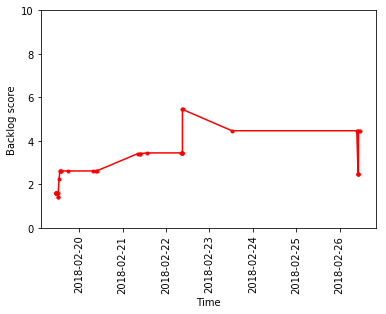

In [98]:
score = round(sum(rules['score']), 2)

#refresh stored data
%store -r

#if data frame for scores is not loaded create it
if not 'scores' in globals():
    scores = pd.DataFrame()
    scores['date'] = ''
    scores['score'] = 0

#append latest score
scores = scores.append(
            {
             'date': pd.to_datetime('now'),
             'score': score,
            }, ignore_index=True)

#store scores for later use
%store scores

print("Backlog score {} / 10".format(score))

_ = plt.plot(scores['date'], scores['score'], "-r.")

_ = plt.xticks(rotation='vertical')
_ = plt.ylabel('Backlog score')
_ = plt.xlabel('Time')
axes = plt.gca()
axes.set_ylim([0,10])




As you can see there is a lot of space for improvement on chart above. I'd recommend to send it to your team and especially Product Owner every week.

If you're interested in other notebooks that could help you working with agile teams take a look at this Github repository: https://github.com/robert-krasinski/JiraAndPythonForManagers
